In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn

from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import multitask_dep as mt
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tasks = ['to','as','about']

In [4]:
encoding_type = 'brk'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = mt.Vocabulary(data['train'],encoding_type)

convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab,word_to_index) 

In [7]:
convai_train_dataset =rrnn.DatasetMultiTaskRRNN(convai_train_token,tasks,eval=False,deps=True)

In [8]:
convai_val_dataset = rrnn.DatasetMultiTaskRRNN(convai_val_token,tasks,eval=False,deps=True)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab,word_to_index) 


md_dataset  = rrnn.DatasetMultiTaskRRNN(md_tokenized,tasks,eval=True,deps=True)

# Creación dataloaders

In [11]:
dl_train =  DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep_multi)
dl_val = DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep_multi)
dl_eval  = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep_multi)

# Pruebas hiperparámetros 1

In [12]:
emb_dim = 20
vocab_size = len(word_to_index)
lstm_hidden_dim = 128

In [13]:
num_epochs = 100
learning_rate = 5e-5

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.075593798002715 	 Validation loss: 2.0815091860496393 	 
  1%|          | 574/57400 [00:07<10:45, 88.03it/s]
Epoch 2 	 Training loss: 2.073821184942531 	 Validation loss: 2.077491141981998 	 
  2%|▏         | 1148/57400 [00:14<10:54, 85.97it/s]
Epoch 3 	 Training loss: 2.071136195485185 	 Validation loss: 2.0758679640495172 	 
  3%|▎         | 1722/57400 [00:21<10:31, 88.22it/s]
Epoch 4 	 Training loss: 2.068045930995343 	 Validation loss: 2.071589433540732 	 
  4%|▍         | 2296/57400 [00:28<10:37, 86.43it/s]
Epoch 5 	 Training loss: 2.0658006576710877 	 Validation loss: 2.071339138483597 	 
  5%|▌         | 2870/57400 [00:35<10:28, 86.76it/s]
Epoch 6 	 Training loss: 2.064469843791337 	 Validation loss: 2.07025910636126 	 
  6%|▌         | 3444/57400 [00:42<10:19, 87.05it/s]
Epoch 7 	 Training loss: 2.06310887245351 	 Validation loss: 2.0736702013823947 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [00:49<10:12, 87.20it/s]
Epoch 8 	 Training

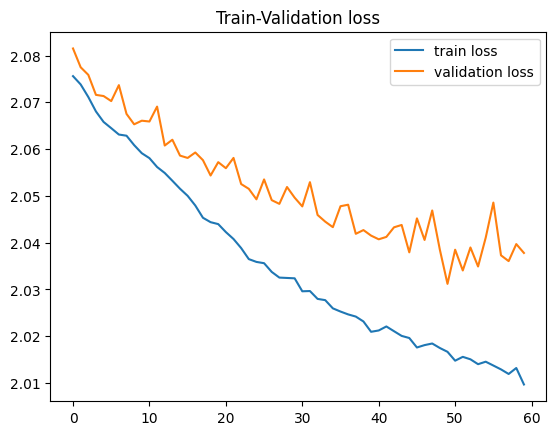

In [14]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_multi_{encoding_type}_v1_1'
optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [15]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Evaluación del modelo
{'to': {'recall': 0.5593434343434344, 'precision': 0.5593434343434344, 'f1': 0.5593434343434344, 'accuracy': 0.5593434343434344}, 'as': {'recall': 0.6075619295958279, 'precision': 0.6075619295958279, 'f1': 0.6075619295958279, 'accuracy': 0.6075619295958279}, 'about': {'recall': 0.6568877551020408, 'precision': 0.6568877551020408, 'f1': 0.6568877551020408, 'accuracy': 0.6568877551020408}} 

Evaluación en etiquetas male
{'to': {'recall': 0.683698296836983, 'precision': 0.683698296836983, 'f1': 0.683698296836983, 'accuracy': 0.683698296836983}, 'as': {'recall': 0.7146464646464646, 'precision': 0.7146464646464646, 'f1': 0.7146464646464646, 'accuracy': 0.7146464646464646}, 'about': {'recall': 0.7994791666666666, 'precision': 0.7994791666666666, 'f1': 0.7994791666666666, 'accuracy': 0.7994791666666666}} 

Evaluación en etiquetas female
{'to': {'recall': 0.4251968503937008, 'precision': 0.4251968503937008, 'f1': 0.4251968503937008, 'accuracy': 0.4251968503937008}, 'as': 

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0756194591522217 	 Validation loss: 2.081382630235058 	 
  1%|          | 574/57400 [00:07<10:41, 88.53it/s]
Epoch 2 	 Training loss: 2.074010268736384 	 Validation loss: 2.07875712039107 	 
  2%|▏         | 1148/57400 [00:14<10:48, 86.73it/s]
Epoch 3 	 Training loss: 2.0701410055991247 	 Validation loss: 2.076185610334752 	 
  3%|▎         | 1722/57400 [00:21<20:37, 45.01it/s]
Epoch 4 	 Training loss: 2.0659931420449182 	 Validation loss: 2.0708273588600807 	 
  4%|▍         | 2296/57400 [00:28<10:41, 85.86it/s]
Epoch 5 	 Training loss: 2.062586759025627 	 Validation loss: 2.0694297370264088 	 
  5%|▌         | 2870/57400 [00:36<10:35, 85.77it/s]
Epoch 6 	 Training loss: 2.0601000079709895 	 Validation loss: 2.0718300261739957 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:43<10:19, 87.03it/s]
Epoch 7 	 Training loss: 2.0585412129707867 	 Validation loss: 2.0652541346469167 	 
  7%|▋         | 4018/57400 [00:50<10:05, 88.12it/s]
Epoch 8 	 Tr

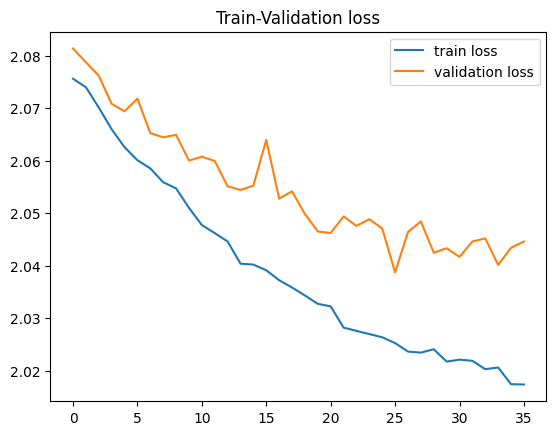

In [16]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)

save_path=f'm1_rrnn_multi_{encoding_type}_v1_2'
optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [17]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Evaluación del modelo
{'to': {'recall': 0.5416666666666666, 'precision': 0.5416666666666666, 'f1': 0.5416666666666666, 'accuracy': 0.5416666666666666}, 'as': {'recall': 0.5893089960886571, 'precision': 0.5893089960886571, 'f1': 0.5893089960886571, 'accuracy': 0.5893089960886571}, 'about': {'recall': 0.6721938775510204, 'precision': 0.6721938775510204, 'f1': 0.6721938775510204, 'accuracy': 0.6721938775510204}} 

Evaluación en etiquetas male
{'to': {'recall': 0.45742092457420924, 'precision': 0.45742092457420924, 'f1': 0.45742092457420924, 'accuracy': 0.45742092457420924}, 'as': {'recall': 0.4722222222222222, 'precision': 0.4722222222222222, 'f1': 0.4722222222222222, 'accuracy': 0.4722222222222222}, 'about': {'recall': 0.6354166666666666, 'precision': 0.6354166666666666, 'f1': 0.6354166666666666, 'accuracy': 0.6354166666666666}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6325459317585301, 'precision': 0.6325459317585301, 'f1': 0.6325459317585301, 'accuracy': 0.6325459317585301}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0759129981130675 	 Validation loss: 2.0807143833677646 	 
  1%|          | 574/57400 [00:07<10:53, 87.00it/s]
Epoch 2 	 Training loss: 2.0741721566130473 	 Validation loss: 2.0814479609667242 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:14<10:54, 85.94it/s]
Epoch 3 	 Training loss: 2.0696253510717733 	 Validation loss: 2.071061405084901 	 
  3%|▎         | 1722/57400 [00:21<10:36, 87.52it/s]
Epoch 4 	 Training loss: 2.0666865388690803 	 Validation loss: 2.076210579629672 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:28<10:28, 87.73it/s]
Epoch 5 	 Training loss: 2.063243527861007 	 Validation loss: 2.072505696345184 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:35<10:29, 86.63it/s]
Epoch 6 	 Training loss: 2.0618313777322137 	 Validation loss: 2.069358668084872 	 
  6%|▌         | 3444/57400 [00:42<10:25, 86.21it/s]
Epoch 7 	 Training loss: 2.0608734569483103 	 Validation loss: 2.0680728766877774 	 
  7%|▋

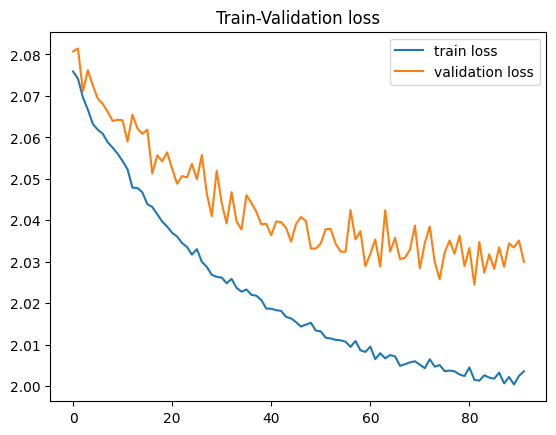

In [18]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)

save_path=f'm1_rrnn_multi_{encoding_type}_v1_3'
optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [19]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Evaluación del modelo
{'to': {'recall': 0.5934343434343434, 'precision': 0.5934343434343434, 'f1': 0.5934343434343434, 'accuracy': 0.5934343434343434}, 'as': {'recall': 0.6323337679269883, 'precision': 0.6323337679269883, 'f1': 0.6323337679269883, 'accuracy': 0.6323337679269883}, 'about': {'recall': 0.6951530612244898, 'precision': 0.6951530612244898, 'f1': 0.6951530612244898, 'accuracy': 0.6951530612244898}} 

Evaluación en etiquetas male
{'to': {'recall': 0.6180048661800487, 'precision': 0.6180048661800487, 'f1': 0.6180048661800487, 'accuracy': 0.6180048661800487}, 'as': {'recall': 0.6111111111111112, 'precision': 0.6111111111111112, 'f1': 0.6111111111111112, 'accuracy': 0.6111111111111112}, 'about': {'recall': 0.7552083333333334, 'precision': 0.7552083333333334, 'f1': 0.7552083333333334, 'accuracy': 0.7552083333333334}} 

Evaluación en etiquetas female
{'to': {'recall': 0.5669291338582677, 'precision': 0.5669291338582677, 'f1': 0.5669291338582677, 'accuracy': 0.5669291338582677}, 'a

In [20]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.6747448979591837, 'precision': 0.6747448979591837, 'f1': 0.6747448979591837, 'accuracy': 0.6747448979591837}
Métricas etiqueta male: {'recall': 0.7300347222222222, 'precision': 0.7300347222222222, 'f1': 0.7300347222222222, 'accuracy': 0.7300347222222222}
Métricas etiqueta female:  {'recall': 0.6216666666666667, 'precision': 0.6216666666666667, 'f1': 0.6216666666666667, 'accuracy': 0.6216666666666667}

 to
Resultado global: {'recall': 0.5648148148148148, 'precision': 0.5648148148148148, 'f1': 0.5648148148148148, 'accuracy': 0.5648148148148148}
Métricas etiqueta male: {'recall': 0.586374695863747, 'precision': 0.586374695863747, 'f1': 0.586374695863747, 'accuracy': 0.586374695863747}
Métricas etiqueta female:  {'recall': 0.5415573053368329, 'precision': 0.5415573053368329, 'f1': 0.5415573053368329, 'accuracy': 0.5415573053368329}

 as
Resultado global: {'recall': 0.6097348978704911, 'precision': 0.6097348978704911, 'f1': 0.60973